In [1]:
#!/bin/env python3

import json
import os
import logging
from datetime import date

import requests
import httplib2
from oauth2client import client

from oauth2client import tools
from oauth2client.file import Storage

from apiclient import discovery

import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

url = 'https://api.etherscan.io/api?module=account&action=txlist&address=0xd0a6e6c54dbc68db5db3a091b171a77407ff7ccf&startblock=0&endblock=99999999&page=<page>&offset=10000&sort=asc&apikey=<APIKEY>'

length_of_auction = 5 * 24 *3600

In [2]:
# Insert your api key here:
api_key = 'YOUR_API_KEY'

In [3]:
url = url.replace('<APIKEY>', api_key)

# Get USD price of ETH

In [4]:
# BTC price
r = requests.get('https://www.bitstamp.net/api/v2/ticker/btcusd/')
data = json.loads(r.text)
btc_usd = data['last']
btc_usd = float(btc_usd)

# ETH price
r = requests.get('https://poloniex.com/public?command=returnTicker')
data = json.loads(r.text)

eth_usd = btc_usd * float(data["BTC_ETH"]["last"])
print("1 ETH = %.4f USD" % eth_usd)

1 ETH = 310.4127 USD


# Get EOS ICO transactions

In [5]:
eos_transactions = []
page = 0

while(True):
    page += 1
    url_temp = url.replace('<page>', str(page))
    r = requests.get(url_temp)
    temp = json.loads(r.text)
    
    if(len(temp['result']) == 0):
        print("...done...")
        break
    
    eos_transactions = eos_transactions + temp['result']
    print("Page: %d, txs: %d" % (page, len(eos_transactions)))

Page: 1, txs: 10000
Page: 2, txs: 18852
...done...


In [6]:
eth_sent = np.array([float(tx['value']) for tx in eos_transactions if tx['isError'] == '0'])
time = np.array([float(tx['timeStamp']) for tx in eos_transactions if tx['isError'] == '0'])

# type(eth_sent[0])
eth_sent_cumsum = np.cumsum(eth_sent)

nonz = eth_sent_cumsum > 0
eth_sent_cumsum = eth_sent_cumsum[nonz]
time = time[nonz]
time = time - time[0]
time = time / 3600

eth_sent_cumsum = eth_sent_cumsum / 1e18

### Logarithmic Interpolation

In [7]:
# y = a * log(x) + b

yunbi = np.sum(eth_sent_cumsum < 150000)
yunbi_amount = eth_sent_cumsum[yunbi] - eth_sent_cumsum[yunbi-1]
print("Yunbi: %d" % yunbi)
print("Yunbi amount: %d ETH" % yunbi_amount)

mega = np.sum(eth_sent_cumsum < 229000)
mega_amount = eth_sent_cumsum[mega] - eth_sent_cumsum[mega-1]
print("mega: %d" % mega)
print("mega amount: %d ETH" % mega_amount)

# Exclude the influence of outliers to get overall trend
eth_sent_cumsum_no_outliers = np.array(eth_sent_cumsum)
eth_sent_cumsum_no_outliers[yunbi:] = eth_sent_cumsum_no_outliers[yunbi:] - yunbi_amount
# eth_sent_cumsum_no_outliers[mega:] = eth_sent_cumsum_no_outliers[mega:] - mega_amount

# a,b = np.polyfit(np.log(time[:yunbi]+1), eth_sent_cumsum[:yunbi], 1, w=eth_sent_cumsum[:yunbi])
a,b = np.polyfit(np.log(time+1), eth_sent_cumsum_no_outliers, 1, w=eth_sent_cumsum_no_outliers)

# from scipy.optimize import curve_fit
# a,b = curve_fit(lambda t,a,b: a*np.log(t)+b,  time+1,  usd_sent_cumsum,  p0=(1.35e6, 1))[0]
# a,b = curve_fit(lambda t,a,b: a*np.log(t)+b,  time+1,  usd_sent_cumsum,  p0=(1e5, 1))[0]

log_interpol = a * np.log(time + 1) + b

time_extrapol = np.array(range(int(time[-1] * 3600), length_of_auction)) / 3600
log_extrapol = a * np.log(time_extrapol + 1) + b

Yunbi: 12117
Yunbi amount: 150000 ETH
mega: 13717
mega amount: 1800 ETH


In [8]:
SHOW_EXTRAPOLATION = True

<IPython.core.display.Javascript object>


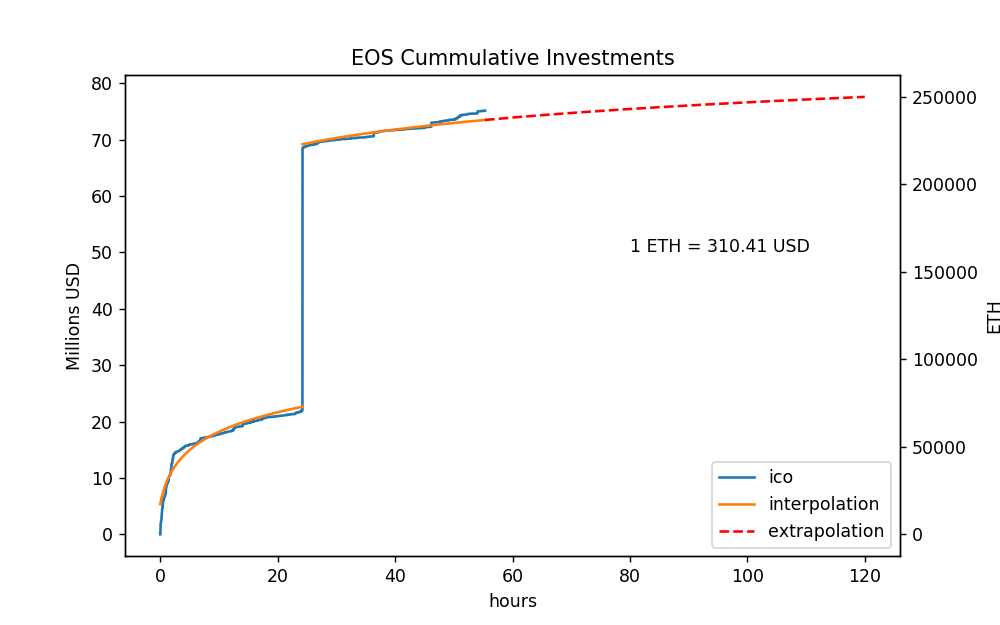

USD raised: 75,157,924.99 USD / 242,122.59 ETH

EOS price: 0.3758 USD / 0.001211 ETH

Predicted EOS price: 0.3880 USD / 0.001250 ETH


In [9]:
plt.figure(figsize=(8,5))

# DDOS attack on ETH
# attack_start = time[-1] - 2*3600 - 44*60 # = 15319.0
# attack_start = 15319.0 / 3600
# plt.plot([attack_start,attack_start], [np.min(log_interpol), np.max(usd_sent_cumsum)], 'k', label='attack')

multiplier = eth_usd/1e6

plt.plot(time, eth_sent_cumsum * multiplier, label='ico')
plt.title("EOS Cummulative Investments")

plt.plot(time[:yunbi], log_interpol[:yunbi] * multiplier, label='interpolation', color = 'C1')
plt.plot(time[yunbi:mega], (log_interpol[yunbi:mega] + yunbi_amount) * multiplier, color = 'C1')
# plt.plot(time[mega:], (log_interpol[mega:len(time)] + yunbi_amount + mega_amount) * multiplier, color = 'C1')
plt.plot(time[mega:], (log_interpol[mega:len(time)] + yunbi_amount) * multiplier, color = 'C1')

if(SHOW_EXTRAPOLATION):
#     plt.plot(time_extrapol, (log_extrapol + yunbi_amount + mega_amount) * multiplier, 'r--', label='extrapolation')
    plt.plot(time_extrapol, (log_extrapol + yunbi_amount) * multiplier, 'r--', label='extrapolation')

plt.xlabel('hours')
plt.ylabel('Millions USD')
plt.text(80,50,'1 ETH = {:,.2f} USD'.format(eth_usd))

plt.legend()

ax2 = plt.twinx()
ax2.plot(time[0], eth_sent_cumsum[0])
ax2.plot(time_extrapol[-1], (log_extrapol + yunbi_amount)[-1], 'r')
ax2.set_ylabel('ETH')

plt.show()

eth_raised = eth_sent_cumsum[-1]
eos_eth = eth_raised / 2e8

# eos_eth_end_window = (log_extrapol + yunbi_amount + mega_amount)[-1] / 2e8
eos_eth_end_window = (log_extrapol + yunbi_amount)[-1] / 2e8

print("USD raised: {:,.2f} USD / {:,.2f} ETH".format(eth_raised * eth_usd, eth_raised))

print("")

print("EOS price: {:,.4f} USD / {:,.6f} ETH".format(eos_eth * eth_usd, eos_eth))

print("")

print("Predicted EOS price: {:,.4f} USD / {:,.6f} ETH".format(eos_eth_end_window * eth_usd, eos_eth_end_window))

# EOS Current Token Distribution

In [10]:
eos_distribution = {}
for tx in eos_transactions:
    if(tx['from'] in eos_transactions):
        eos_distribution[tx['from']] += float(tx['value']) / 1e18
    else:
        if(float(tx['value']) > 0):
            eos_distribution[tx['from']] = float(tx['value']) / 1e18

print("Number of addresses: %d" % (len(eos_distribution.keys())))

Number of addresses: 8538


In [11]:
eos_stakes = np.array(list(eos_distribution.values())) / eth_sent_cumsum[-1] * 100
limit = 100
eos_stakes = np.sort(eos_stakes)

<IPython.core.display.Javascript object>


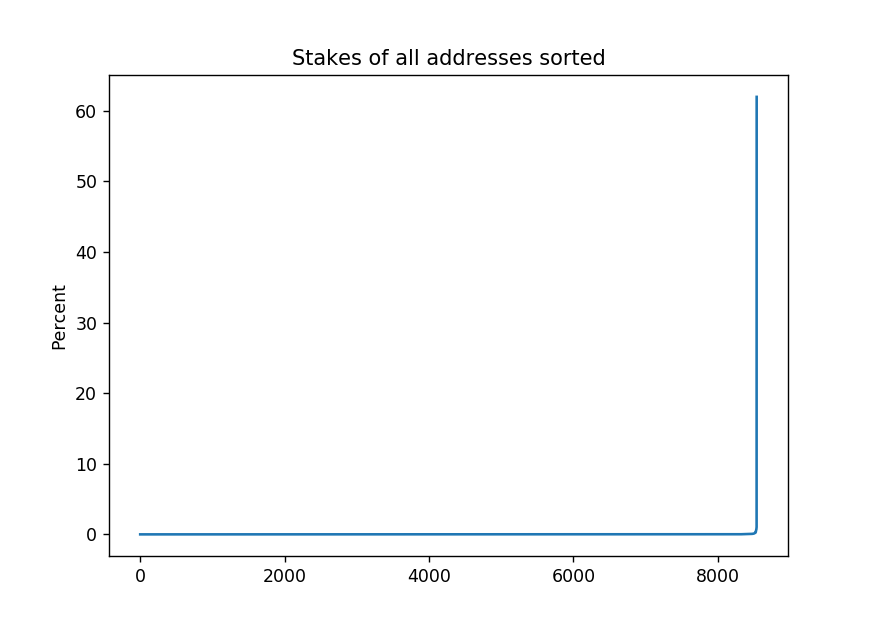

In [12]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.plot(eos_stakes)
ax.set_title('Stakes of all addresses sorted')
ax.set_ylabel('Percent');

### Yunbi removed in following figures

<IPython.core.display.Javascript object>


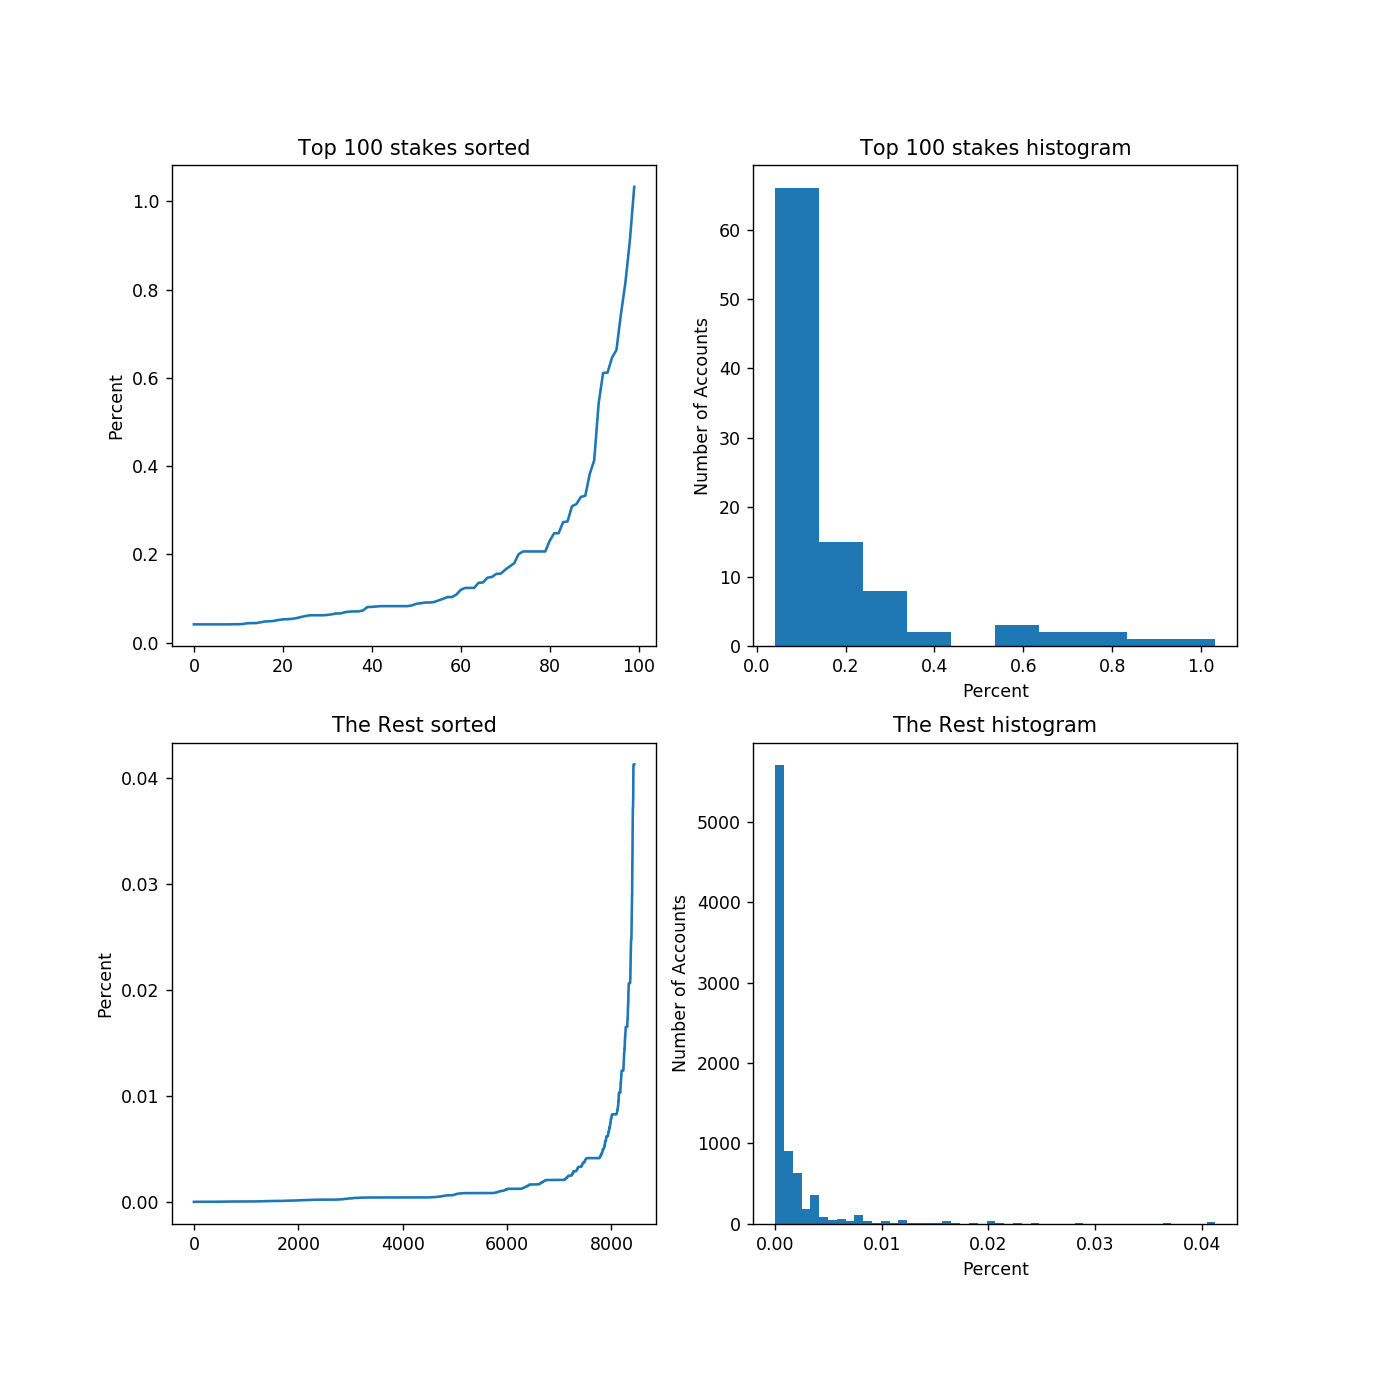

In [13]:
eos_top_stakes = eos_stakes[-limit-1:-1]
eos_the_rest = eos_stakes[:-limit-1]

fig, ax = plt.subplots(2,2, figsize=(11, 11))
ax[0,0].plot(eos_top_stakes)
# ax[0,0].plot(eos_top_stakes,".")
ax[0,0].set_title('Top 100 stakes sorted')
ax[0,0].set_ylabel('Percent');

ax[0,1].hist(eos_top_stakes, 10)
ax[0,1].set_title('Top 100 stakes histogram')
ax[0,1].set_xlabel('Percent');
ax[0,1].set_ylabel('Number of Accounts');

ax[1,0].plot(eos_the_rest);
# ax[0,1].plot(eos_the_rest, ".");
ax[1,0].set_title('The Rest sorted')
ax[1,0].set_ylabel('Percent');

ax[1,1].hist(eos_the_rest, 50);
ax[1,1].set_title('The Rest histogram');
ax[1,1].set_xlabel('Percent');
ax[1,1].set_ylabel('Number of Accounts');

# Future work: Analysis of all auction windows